In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import (
    MapAxis,
    WcsGeom,
    RegionGeom,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    FluxPointsDataset,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SkyModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [2]:
# Customize the pyplot figure:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': '--',
})

# Load DL3 data

In [3]:
# ================
# === Settings ===
# ================

# input_dir = '/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/' \
#             '5.dl2_to_dl3/data/dl3/software_gam_dynamic0.9_theta_global0.2'

# obs_ids = [3267, 3268]
    
input_dir = '/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/magic_only_analysis/' \
            '5.dl2_to_dl3/data/dl3/magic_stereo_gam_dynamic0.9_theta_global0.2'

obs_ids = [5093713, 5093714]

# ============
# === Main ===
# ============

data_store = DataStore.from_dir(input_dir)

if obs_ids == 'all':
    obs_ids = data_store.obs_table['OBS_ID'].value

observations = data_store.get_observations(obs_ids, required_irf=['aeff', 'edisp'])

print(observations)

No HDU found matching: OBS_ID = 5093713, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = rad_max, HDU_CLASS = None


Observations
Number of observations: 2
Observation

	obs id            : 5093713 
 	tstart            : 59198.92
	tstop             : 59198.93
	duration          : 882.17 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093714 
 	tstart            : 59198.93
	tstop             : 59198.94
	duration          : 883.06 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.0%



# Define a target region

In [4]:
# Read one of the input files to get the meta data:
file_name = data_store.hdu_table['FILE_NAME'][0]
path_to_file = f'{input_dir}/{file_name}'

hdu_events = Table.read(path_to_file, hdu='EVENTS')
hdu_aeff = Table.read(path_to_file, hdu='EFFECTIVE AREA')

# Get the target position from the meta data:
target_position = SkyCoord(
    u.Quantity(hdu_events.meta['RA_OBJ'], u.deg),
    u.Quantity(hdu_events.meta['DEC_OBJ'], u.deg), 
    frame='icrs',
)

# Here it assumes that the IRFs are created with a global theta cut:
on_region_radius = u.Quantity(hdu_aeff.meta['RAD_MAX'], u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.2 deg


# Create an exclusion mask

In [5]:
# ================
# === Settings ===
# ================

exclusion_position_name = 'RGB J0521+212'
exclusion_region_radius = u.Quantity(0.5, u.deg)

# ============
# === Main ===
# ============

exclusion_position = SkyCoord.from_name(exclusion_position_name, frame='icrs')
exclusion_region = CircleSkyRegion(center=exclusion_position, radius=exclusion_region_radius)

print(exclusion_region)

geom = WcsGeom.create(
    npix=(800, 800), binsz=0.01,
    skydir=target_position, proj='TAN', frame='icrs',
)

exclusion_mask = ~geom.region_mask([exclusion_region])

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (80.44152391, 21.21429244)>
radius: 0.5 deg


# Run the data reduction chain

In [6]:
# ================
# === Settings ===
# ================

energy_reco_min = 0.1   # unit: [TeV]
energy_reco_max = 4   # unit: [TeV]
n_reco_bins_pdec = 5

energy_true_min = 0.01   # unit: [TeV]
energy_true_max = 100   # unit: [TeV]
n_true_bins_pdec = 10

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_reco_min, energy_reco_max, nbin=n_reco_bins_pdec,
    per_decade=True, unit='TeV', name='energy',
)

energy_axis_true = MapAxis.from_energy_bounds(
    energy_true_min, energy_true_max, nbin=n_true_bins_pdec,
    per_decade=True, unit='TeV', name='energy_true',
)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

print('Reconstructed energy axis:')
print(energy_axis.edges)

Reconstructed energy axis:
[0.1        0.15066302 0.22699345 0.34199519 0.51526028 0.77630669
 1.1696071  1.76216536 2.65493153 4.        ] TeV


In [7]:
# Define a SpectrumDatasetMaker, assuming tha the input is point-like IRFs.
# Even if the "use_region_center" is set to True, there will be following warning when using gammapy v0.19:
# "MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate"
# It can be safely ignored and will not appear in the next version of gammapy:

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=['counts', 'exposure', 'edisp'], use_region_center=True,
)

bkg_maker = ReflectedRegionsBackgroundMaker(
     exclusion_mask=exclusion_mask, min_distance=u.Quantity(100, u.deg), max_region_number=1,
)

safe_mask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

print(dataset_maker)

SpectrumDatasetMaker
--------------------

  selection               : {'exposure', 'counts', 'edisp'}
  containment_correction  : False
  background_oversampling : None
  use_region_center       : True



In [8]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    
    datasets.append(dataset_on_off)

print(datasets)

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 5093713
  Instrument : CTA-N
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 5093714
  Instrument : CTA-N
  Models     : 




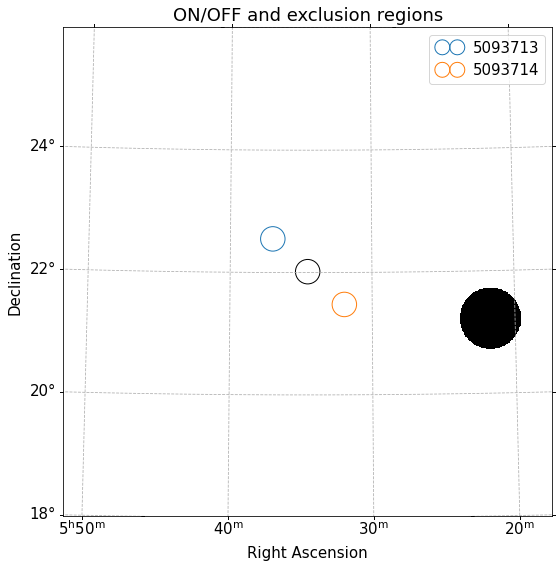

In [9]:
plt.figure()

ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor='black')

plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

ax.set_title('ON/OFF and exclusion regions')
ax.grid()

# Check source statistics

In [10]:
info_table = datasets.info_table(cumulative=True)

In [11]:
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,479,235.0,244.0,9.224297674407914,357.0,357.0,nan,35.70296859741211,245641712.0,882.1718831062317,882.1718831062317,0.5429780853062153,0.2663879959226734,0.2765900893835418,9,8,wstat,125.33781603089034,235,8.0,8.0,1.0
stacked,926,464.0,462.0,12.510676095262284,695.0,695.0,nan,71.4417724609375,491529920.0,1765.229032278061,1765.229032278061,0.5245778213861461,0.26285540942027186,0.26172241196587415,9,8,wstat,212.5868852991834,464,8.0,8.0,1.0


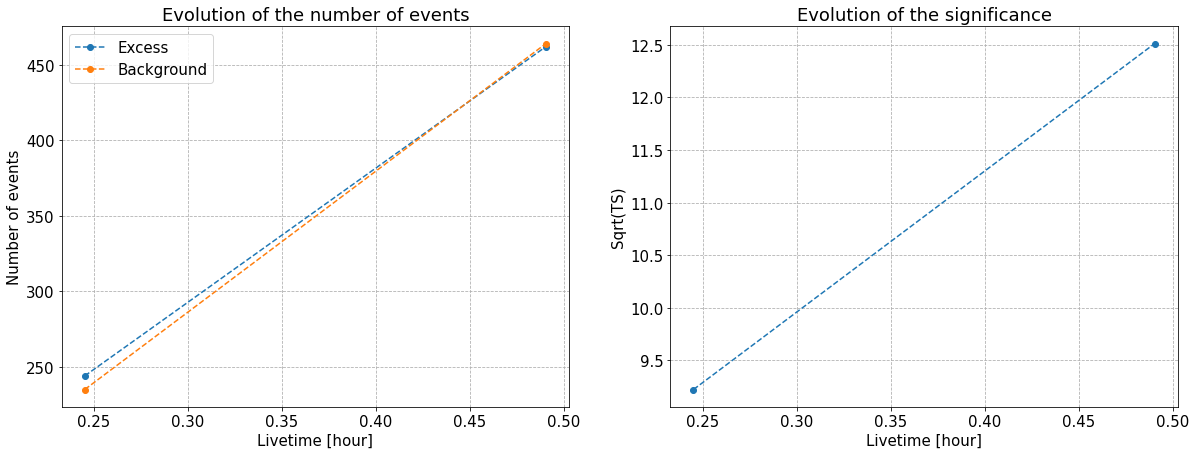

In [12]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Livetime vs N events:
plt.subplot2grid(grid, (0, 0))
plt.title('Evolution of the number of events')
plt.xlabel('Livetime [hour]')
plt.ylabel('Number of events')

plt.plot(
    info_table['livetime'].to('h'), info_table['excess'],
    marker='o', linestyle='--', label='Excess'
)

plt.plot(
    info_table['livetime'].to('h'), info_table['background'],
    marker='o', linestyle='--', label='Background',
)

plt.grid()
plt.legend()

# Livetime vs Sqrt(TS):
plt.subplot2grid(grid, (0, 1))
plt.title('Evolution of the significance')
plt.xlabel('Livetime [hour]')
plt.ylabel('Sqrt(TS)')

plt.plot(
    info_table['livetime'].to('h'), info_table['sqrt_ts'],
    marker='o', linestyle='--',
)

plt.grid()

# Fit a spectrum

In [13]:
# ================
# === Settings ===
# ================

model_function = LogParabolaSpectralModel

parameters = {
    'amplitude': u.Quantity(5e-12, u.Unit('cm-2 s-1 TeV-1')),
    'alpha': u.Quantity(2),
    'beta': u.Quantity(0.1),
    'reference': u.Quantity(1, u.TeV),
}

# ============
# === Main ===
# ============

spectral_model = model_function(**parameters)
model = SkyModel(spectral_model=spectral_model, name='target_source')

stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = model

fit = Fit()
results = fit.run(datasets=stacked_dataset)

print(results)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 156
	total stat : 1.93

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 156
	total stat : 1.93




In [14]:
stacked_dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str13,str8,str9,float64,str14,float64,float64,float64,bool,str1
target_source,spectral,amplitude,2.9227e-11,cm-2 s-1 TeV-1,3.118e-12,nan,nan,False,
target_source,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
target_source,spectral,alpha,2.5967e+00,,1.524e-01,nan,nan,False,
target_source,spectral,beta,1.2420e-01,,1.051e-01,nan,nan,False,


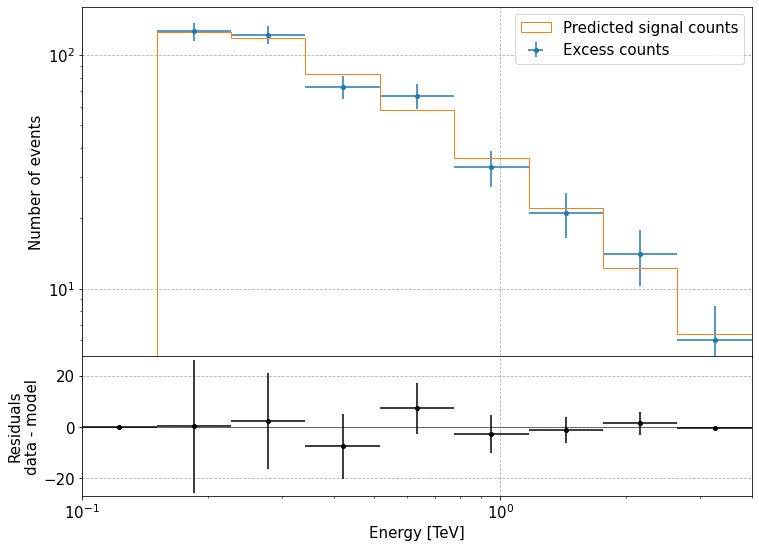

In [15]:
plt.figure()

ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel('Number of events')
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

# Compute flux points

In [16]:
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges,
    source='target_source',
    selection_optional='all',
)

flux_points = fpe.run(datasets=stacked_dataset)
flux_points_dataset = FluxPointsDataset(data=flux_points, models=stacked_dataset.models)

In [17]:
flux_points.to_table(sed_type='e2dnde', formatted=True)

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.123,0.100,0.151,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.185,0.151,0.227,5.645e-11,1.163e-11,1.166e-11,1.161e-11,7.986e-11,23.694,4.868,399.99993673704154,125.99989,0.000,False,400.0,True,0.200 .. 5.000,15.227 .. 294.593
0.279,0.227,0.342,5.270e-11,8.082e-12,8.137e-12,8.037e-12,6.911e-11,43.432,6.590,235.99179793467977,121.98784,0.000,False,236.0,True,0.200 .. 5.000,28.372 .. 388.412
0.420,0.342,0.515,3.933e-11,6.836e-12,6.926e-12,6.764e-12,5.339e-11,34.339,5.860,117.00744250899467,73.01024,0.000,False,117.0,True,0.200 .. 5.000,20.739 .. 347.249
0.632,0.515,0.776,4.323e-11,6.354e-12,6.512e-12,6.216e-12,5.660e-11,50.920,7.136,81.99948579820827,66.99939,0.000,False,82.0,True,0.200 .. 5.000,35.706 .. 225.202
0.953,0.776,1.170,2.739e-11,6.267e-12,6.444e-12,6.127e-12,4.069e-11,20.348,4.511,45.003258572675136,33.004128,0.000,False,45.0,True,0.200 .. 5.000,12.633 .. 160.485
1.436,1.170,1.762,2.197e-11,5.231e-12,5.540e-12,4.961e-12,3.372e-11,20.719,4.552,23.00166422412626,21.001808,0.000,False,23.0,True,0.200 .. 5.000,13.563 .. 105.564
2.163,1.762,2.655,1.964e-11,6.273e-12,6.638e-12,5.999e-12,3.376e-11,10.818,3.289,16.999901109259806,13.999884,0.000,False,17.0,True,0.200 .. 5.000,7.569 .. 47.917


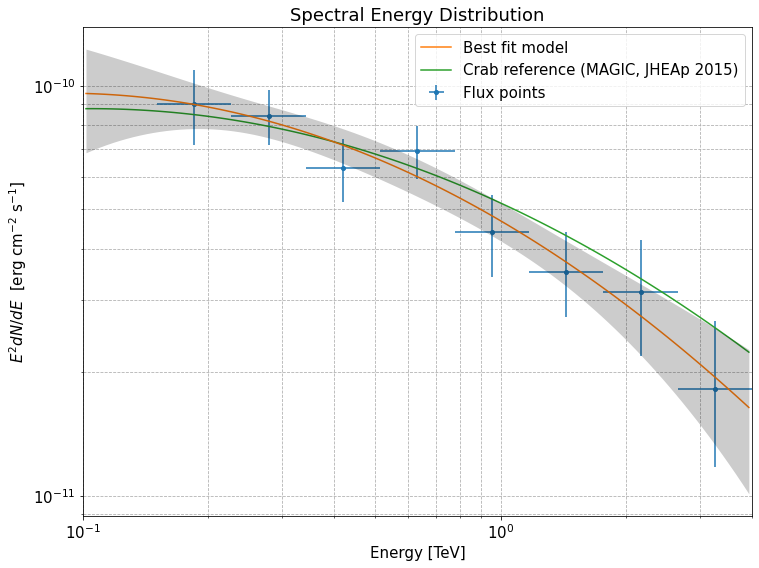

In [18]:
plt.figure()

plot_kwargs = {
    'sed_type': 'e2dnde',
    'yunits': u.Unit('erg cm-2 s-1'),
}

# Plot the computed flux points:
ax = flux_points_dataset.plot_spectrum(kwargs_model=plot_kwargs)

# Draw the Crab reference spectrum:
create_crab_spectral_model('magic_lp').plot(
    ax=ax, energy_bounds=energy_axis.edges[[0, -1]],
    label='Crab reference (MAGIC, JHEAp 2015)', **plot_kwargs,
)

ax.set_title('Spectral Energy Distribution')
ax.set_ylabel('$E^2dN/dE$  [erg cm$^{-2}$ s$^{-1}$]')
ax.grid(which='both')
ax.legend()